# Biweekly Report 3

# Jake Watts

# Exploring Xception Depth

After visualizaing the activation function for my Xception model with ReLU and ELU activations, I realized that the last layers were 1x1 and appeared as if they not be necessary. Here I retrain the Xception model using the ELU activation fucntion (as it was the best performing activation) and reduce the number of layers within the exit flow to see if it improves performance.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

Mounting to google drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading Cifar-10 data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


Normalizing data and one-hot encoding

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Convolution and seperable convolution functions remain the same as previously trained models.

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

Here I modify the exit layer to remove the convolutional layers. My hope is that doing this will imporve performance or at least not decrease performance while decreasing training time.

In [ ]:
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ELU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ELU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ELU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ELU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        tensor = Add()([tensor,x])
        
        return tensor
# exit flow

def exit_flow(tensor):
    x = GlobalAvgPool2D()(tensor)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x

In [ ]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

The new model architecture is shown below.

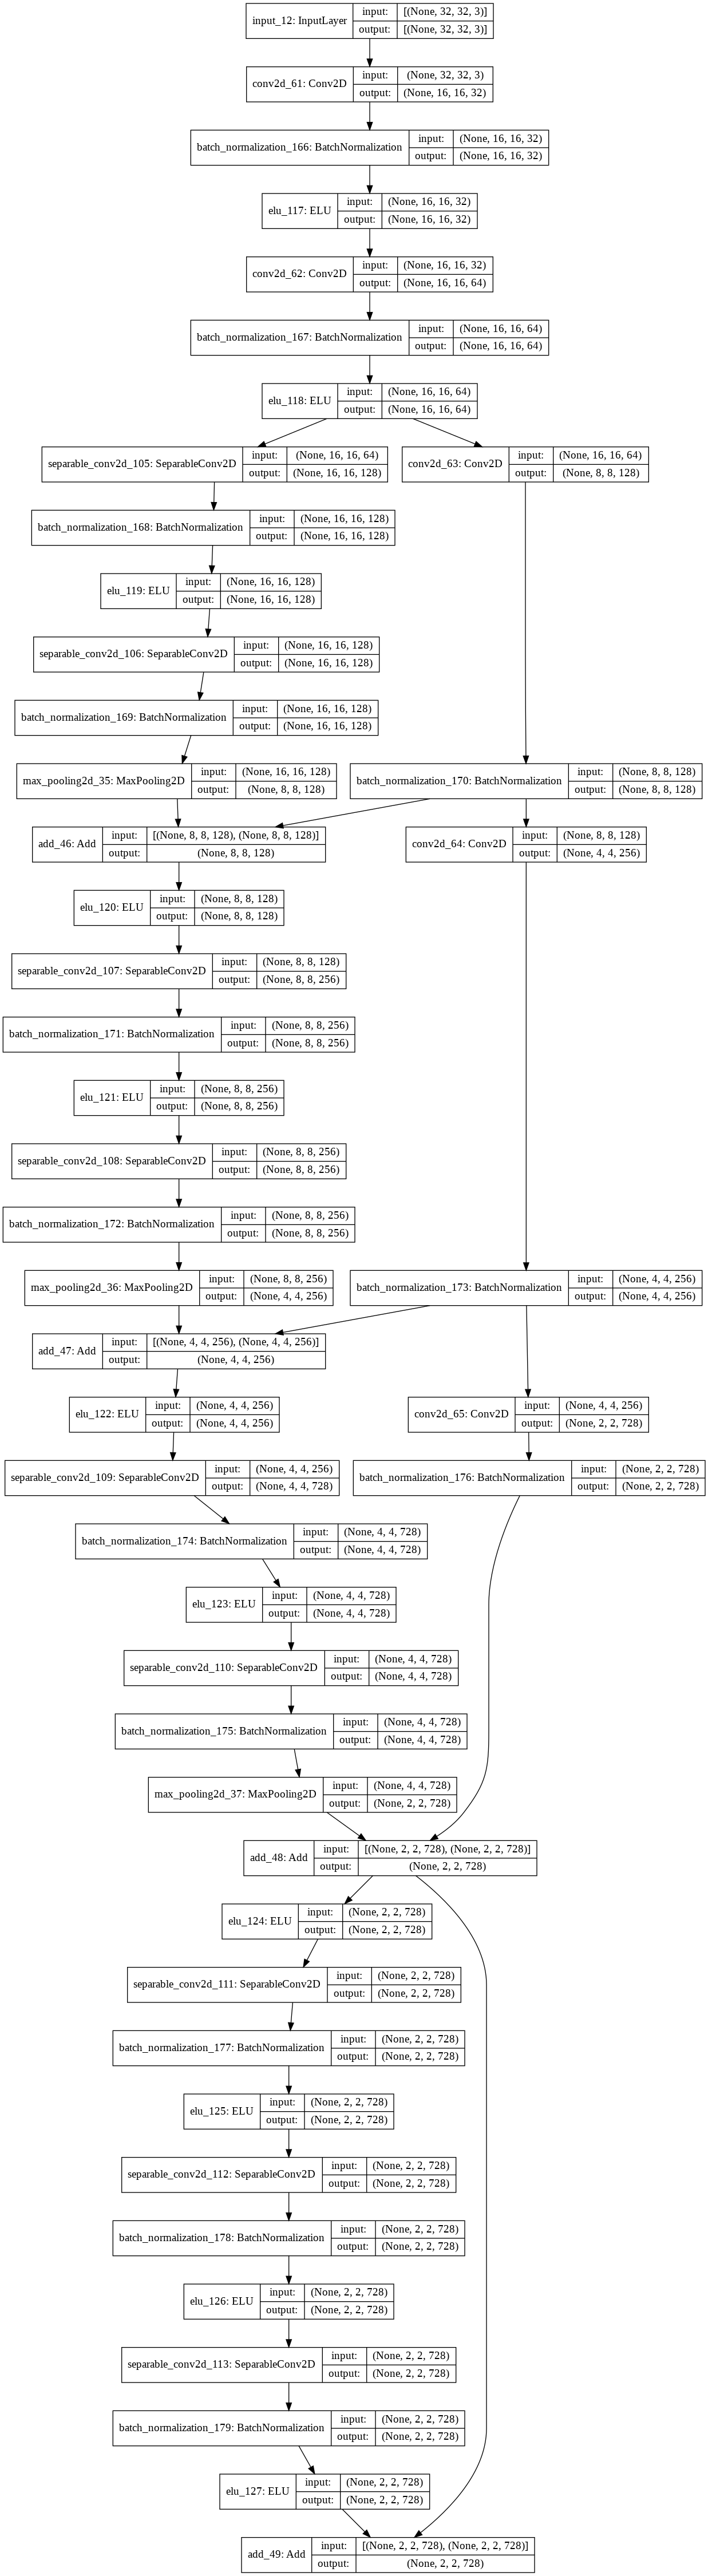

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
filepath = '/content/gdrive/My Drive/cifar10_xception_short.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_callback = model.fit(x_train, y_train, validation_split= 0.2, epochs= 12, callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 35s 14ms/step - loss: 1.4004 - accuracy: 0.5176 - val_loss: 1.1955 - val_accuracy: 0.5961

Epoch 00001: val_loss improved from inf to 1.19547, saving model to /content/gdrive/My Drive/cifar10_xception_short.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9255 - accuracy: 0.6782 - val_loss: 0.9415 - val_accuracy: 0.6738

Epoch 00002: val_loss improved from 1.19547 to 0.94149, saving model to /content/gdrive/My Drive/cifar10_xception_short.h5
Epoch 3/12
1250/1250 [==============================] - 16s 13ms/step - loss: 0.7471 - accuracy: 0.7392 - val_loss: 0.8288 - val_accuracy: 0.7219

Epoch 00003: val_loss improved from 0.94149 to 0.82882, saving model to /content/gdrive/My Drive/cifar10_xception_short.h5
Epoch 4/12
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6199 - accuracy: 0.7831 - val_loss: 0.7924 - val_accuracy: 0.7375

Epoch 00004: val_loss improved from 0.82882 to 0.79235, saving model to /content/gdrive/My Drive/cifar10_xception_short.h5
Epoch 5/12
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5094 - accuracy: 0.8215 - val_loss: 0.6958 - val_accuracy: 0.7663

Epoch 00005: val_loss improved from 0.79235

The validation accuracy still does not increase as rapidly as the training accuracy, however the validation accuracy for this model does increase throughout training more than any other model trained so far.

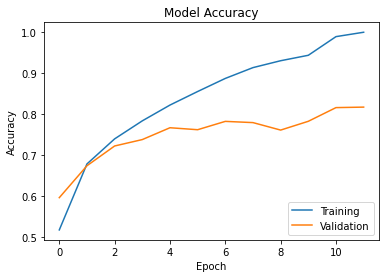

In [ ]:
plt.figure()
plt.plot(h_callback.history['accuracy'])
plt.plot(h_callback.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

When evaluating the model on the test data, the accuracy is higher than when using the full model. This means that decreasing the number of layers within the exit flow helped performance! Also the training time for this model was quicker with less layers.

The accuracy of the Xception model with decreased layers was 80.56%, while the accuracy of the full Xception model was 77.86%.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.7733 - accuracy: 0.8056


[0.7732639312744141, 0.8055999875068665]

# Summary

Decreasing the number of layers in the exit flow appeared to be increase the performance of the model. This implies that the last layers of the Xception model were likely not useful, which I probably wouldn't have realized without visualizing the activations. I think the reason that this model does not need to be as deep is that the Cifar-10 data does not have nearly as many classes, or the amount of pixels that ImageNet does which is what the Xception model was used for in the paper.

Overall I also think it was benficial that I focused on one architecture in this report rather than looking at mutliple architectures as I normally do. Focusing on one architecture gave me a more in-depth understanding of the model and let me experiment more in order to improve performance.